# <font color="#154360"><center>Projet 6 : Réalisez une analyse de sentiments grâce au Deep Learning</center></font>
# <font color="#154360"><center>Partie I - Analyse exploratoire et Preprocessing des données</center></font>

## Préambule 
### 1 - Contexte



### 2 - Chargement des librairies

In [1]:
# Version Python
!python --version

Python 3.12.3


In [2]:
# Librairies pour la manipulation de données
import numpy as np
import pandas as pd
import time
import missingno as msno
import nltk
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import manifold, decomposition, cluster, metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
import gensim
import transformers
from transformers import AutoTokenizer, TFAutoModel
import re
import mlflow
import os

# Suppression des warnings
import warnings
warnings.filterwarnings('ignore')

# Librairies pour la visualisation des données
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from pivottablejs import pivot_ui

# Version bibliothèque partiellement importée
import importlib.metadata

# Version des bibliothèques utilisées
print('\n'.join(f'{m.__name__} - {m.__version__}'
                for m in globals().values()
                if getattr(m, '__version__', None)))
print("matplotlib - ", importlib.metadata.version('matplotlib'))

json - 2.0.9
numpy - 1.26.4
pandas - 2.2.2
tensorflow - 2.18.0
keras - 3.6.0
ipywidgets - 7.8.1
xarray - 2023.6.0
numpy - 1.26.4
pandas - 2.2.2
missingno - 0.5.2
nltk - 3.9.1
tensorflow_hub - 0.16.1
tensorflow - 2.18.0
tensorflow - 2.18.0
gensim - 4.3.3
transformers - 4.46.2
re - 2.2.1
mlflow - 2.18.0
seaborn - 0.13.2
matplotlib -  3.9.2


### 3 - Lecture des fichiers

In [3]:
# Lecture des données textuelles
df_tweet = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", header=None)

## I - Analyse Exploratoire des Données
### 1 - Informations générales

In [4]:
# Descriptif du dataset
df_tweet.info()

# Premières lignes du fichier
display(df_tweet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   0       1600000 non-null  int64 
 1   1       1600000 non-null  int64 
 2   2       1600000 non-null  object
 3   3       1600000 non-null  object
 4   4       1600000 non-null  object
 5   5       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Nous avons à notre disposition un dataset de 1 600 000 lignes pour 6 variables.  
Les données n'ont pas d'entêtes mais il semblerait que nous ayons un `id`, une `date`, un `auteur` et le `tweet` ; les variables `0` et `3` sont en revanche difficilement identifiables.  
Nous n'avons pas réellement de valeurs nulles mais on constate que les colonnes non identifiées ont "0" et "NO_QUERY" en valeur sur ces premières lignes donc elles n'ont peut-être pas grand intérêt pour notre projet. 

### 2 - Exploration et nettoyage des données

#### a - Nombre de valeurs uniques par variables

In [5]:
# Comptage du nombre de valeurs uniques par variables
print("Nombre de valeurs uniques par variable :")
for col in df_tweet:
    print(f"{col} :", len(df_tweet[col].unique()))

Nombre de valeurs uniques par variable :
0 : 2
1 : 1598315
2 : 774363
3 : 1
4 : 659775
5 : 1581466


La variable "3" n'a qu'une valeur donc va pouvoir être supprimée. L'id potentiel a moins de valeurs uniques qu'il y a de lignes dans le dataset donc nous allons devoir aller plus loin pour comprendre à quoi correspondent ces doublons. On voit que la variable "0" contient deux valeurs, il doit certainement sagir du sentiment positif ou négatif du tweet.
Pour les autres variables tout semble cohérent.

In [6]:
# Suppression de la variable '3'
df_tweet = df_tweet.drop(columns = 3)

#### b - Variable `sentiment`

In [7]:
# Nombre de lignes par valeurs dans la variable '0'
sentiment = df_tweet[0].value_counts()
display(sentiment)

0
0    800000
4    800000
Name: count, dtype: int64

Nous avons le même nombre de lignes pour chaque valeur de la variable `0`, nous avons donc un jeu de données avec autant de tweets positifs que négatifs.

#### c - Doublons variable `id`

In [8]:
#Création fonction pour détecter les doublons
def doublon(df, column_name):
    duplicated_values = df[column_name][df[column_name].duplicated()].unique()
    return duplicated_values.tolist()

# Vérif doublon sur la colonne "product_id"      
doublons = doublon(df_tweet, 1)
print("Nombre de doublons :", len(doublon(df_tweet, 1)))
print("Nombre de valeurs uniques :", len(df_tweet[1].unique()))

# Df avec les doublons
df_doublons = df_tweet.loc[df_tweet[1].isin(doublons), :]

# Liste avec les 3 premiers doublons
doublons_3 = (doublon(df_tweet, 1))[:3]

# Affichage des lignes de ces trois doublons dans un df
display(df_tweet.loc[df_tweet[1].isin(doublons_3), :])

Nombre de doublons : 1685
Nombre de valeurs uniques : 1598315


,0,1,2,4,5
213,0,1467863684,Mon Apr 06 22:33:35 PDT 2009,DjGundam,Awwh babs... you look so sad underneith that s...
275,0,1467880442,Mon Apr 06 22:38:04 PDT 2009,iCalvin,Haven't tweeted nearly all day Posted my webs...
989,0,1468053611,Mon Apr 06 23:28:09 PDT 2009,mariejamora,@hellobebe I also send some updates in plurk b...
800261,4,1467863684,Mon Apr 06 22:33:35 PDT 2009,DjGundam,Awwh babs... you look so sad underneith that s...
800300,4,1467880442,Mon Apr 06 22:38:04 PDT 2009,iCalvin,Haven't tweeted nearly all day Posted my webs...
801280,4,1468053611,Mon Apr 06 23:28:09 PDT 2009,mariejamora,@hellobebe I also send some updates in plurk b...


En cumulant nos valeurs uniques et nos doublons nous avons bien l'intégralité de nos lignes, il n'y a donc pas de valeurs en triple ou plus.  
Sur l'échantillon que nous ressortons nous avons strictement les mêmes données avec un sentiment inverse.  
Vérifions si dans notre liste de doublons nous avons le même nombre de positifs et de négatifs.

In [9]:
# Comptage du nombre de 1 et 4 pour les id doublés
sentiment_doublons = df_tweet.loc[df_tweet[1].isin(doublons), :].value_counts(0)
display(sentiment_doublons)

0
0    1685
4    1685
Name: count, dtype: int64

Nous avons bien deux valeurs différentes pour un même tweet, il serait possible d'avoir 3 sentiments avec la notion "neutre" en plus mais l'échantillon de ces derniers est bien trop petit pour que nous puissions l'exploiter. Nous allons donc retirer ces tweets de notre dataset.

In [10]:
# Suppression complète des id qui sont en double
df_tweet = df_tweet.loc[~df_tweet[1].isin(doublons), :].reset_index(drop=True)

In [11]:
# Renommage des variables
df_tweet = df_tweet.rename(columns={0: "sentiment", 1: "id", 2: "date", 4: "auteur", 5: "tweet"})
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596630 entries, 0 to 1596629
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1596630 non-null  int64 
 1   id         1596630 non-null  int64 
 2   date       1596630 non-null  object
 3   auteur     1596630 non-null  object
 4   tweet      1596630 non-null  object
dtypes: int64(2), object(3)
memory usage: 60.9+ MB


Nos variables ont été renommées pour plus de lisibilité, nous n'avons plus que des id uniques avec un seul sentiment associé.

#### d - Temporalité

In [12]:
# Valeur max et min dans la colonne 'date'
print("Première date de tweet :", min(df_tweet["date"]))
print("Dernière date de tweet :", max(df_tweet["date"]))

Première date de tweet : Fri Apr 17 20:30:31 PDT 2009
Dernière date de tweet : Wed May 27 07:27:38 PDT 2009


Les tweets que nous avons à disposition s'étalent entre le 17 avril 2009 et le 27 mai 2009 soit une quarantaine de jours.

#### e - Longueur des tweets

,count,mean,std,min,25%,50%,75%,max
sentiment,,,,,,,,
0,798315.0,13.573609,7.073055,1.0,8.0,13.0,19.0,57.0
4,798315.0,12.760230,6.814235,1.0,7.0,12.0,18.0,64.0


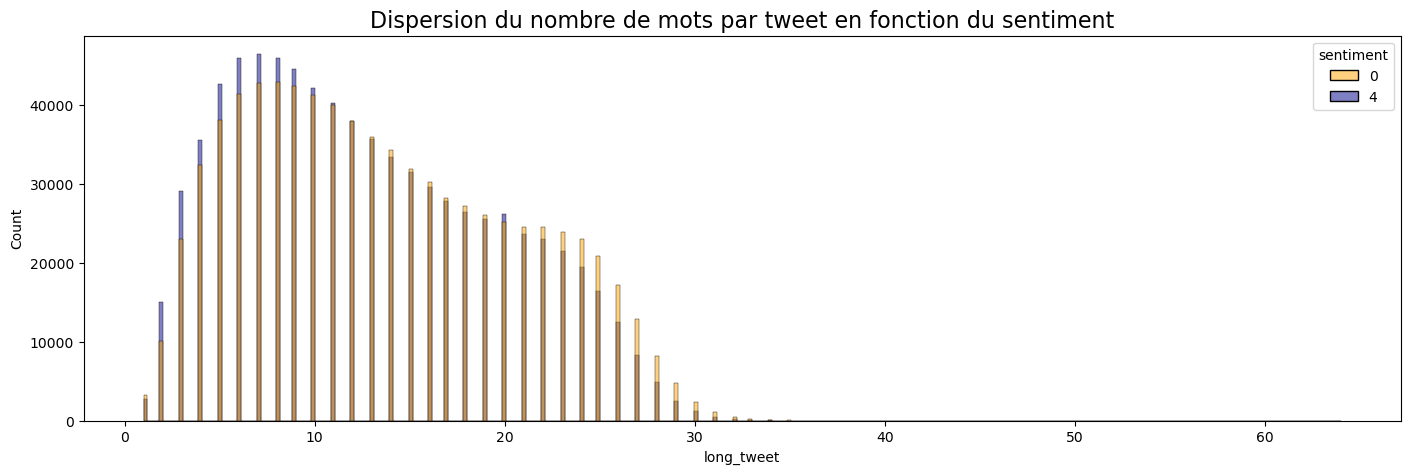

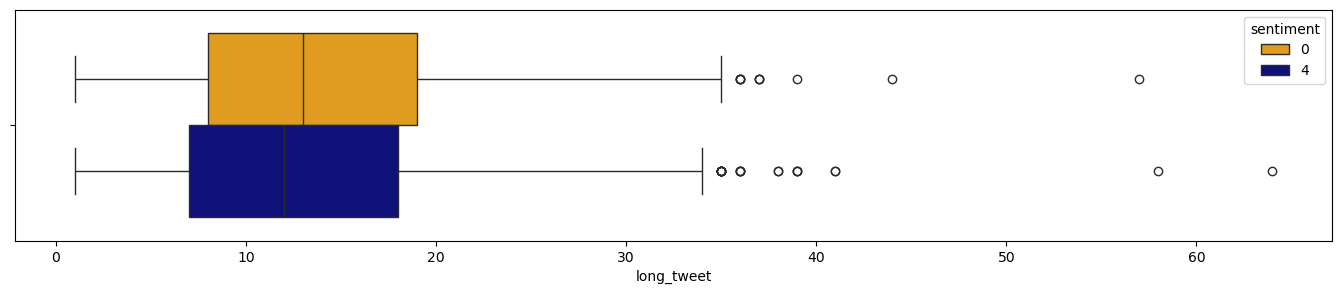

In [13]:
# Fonction lambda pour compter le nombre de mots
long_text = lambda x: len(x.split())

# Calcul de la longueur de la chaîne
df_tweet["long_tweet"] = df_tweet["tweet"].apply(long_text)

# Description sur les longueurs des chaînes
display(pd.DataFrame(df_tweet.groupby("sentiment")["long_tweet"].describe()))

# Visualisation de la dispersion du nombre de mots
palette = {0:"orange", 4:"darkblue"}
plt.figure(figsize=(17, 5))
sns.histplot(df_tweet, x="long_tweet", hue="sentiment", palette=palette)
plt.title("Dispersion du nombre de mots par tweet en fonction du sentiment", size=16)
plt.show()
plt.figure(figsize=(17, 3))
sns.boxplot(df_tweet, x="long_tweet", hue="sentiment", palette=palette)
plt.show()

Nous avons globalement les mêmes formes de dispersion entre les deux sentiments.

#### f - Nuages de mots avant Preprocessing

In [14]:
# Fonction pour générer des nuages de mots
def Nuage_de_mots(df, category_col, text_col):
    categories = df[category_col].unique()  # Obtenir les catégories uniques
    for category in categories:
        # Filtrer les lignes correspondant à cette catégorie
        subset = df[df[category_col] == category]
       
        # Combiner tous les textes dans cette catégorie
        text = " ".join(subset[text_col])
        
        # Générer le nuage de mots
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        # Afficher le nuage de mots
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Nuage de mots pour la catégorie : {category}')
        plt.axis('off')
        plt.show()

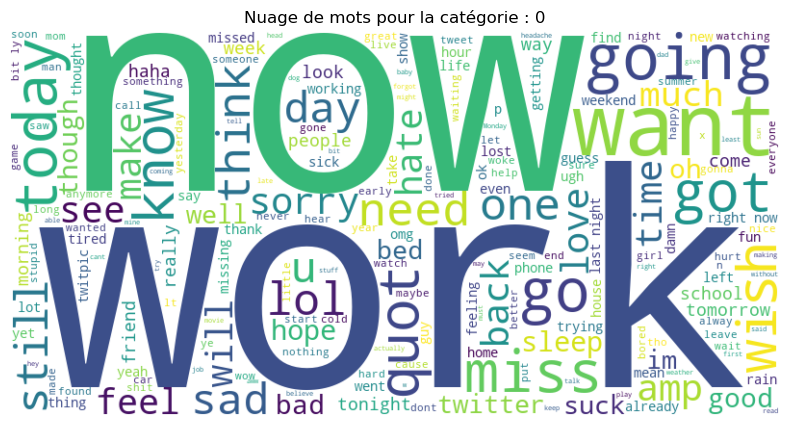

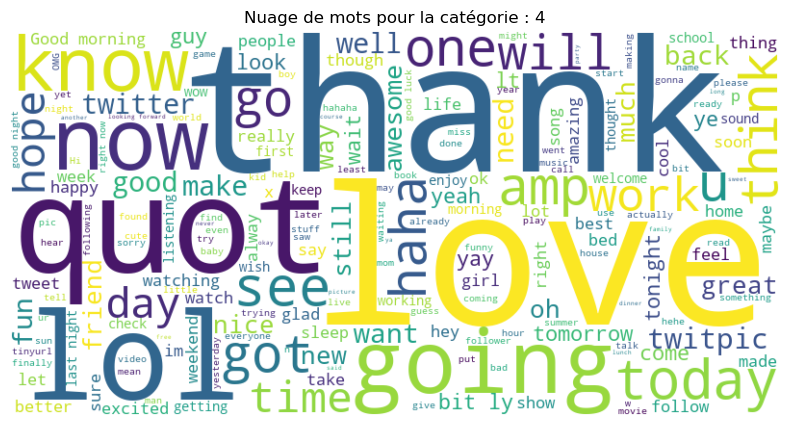

In [15]:
# Appel de la fonction pour générer un nuage de mots par catégorie
Nuage_de_mots(df_tweet, "sentiment", "tweet")

Compte tenu des nuages qui ressortent, la catégorie 0 correspond au sentiment négatif alors que la catégorie 4 correspond au sentiment positif.  
Nous voyons certains mots commun qui ne nous serons donc d'aucune utilité comme 'going', 'got', 'go', etc. 

In [16]:
# Changement de 0 en negatif et 4 en positif pour plus de lisibilité
df_tweet["sentiment"] = ["négatif" if x == 0 else "positif" if x == 4 else x for x in df_tweet["sentiment"]]

# Ajout d'un label encodé en numérique pour les algo
df_tweet["label sentiment"] = [0 if x == "négatif" else 1 if x == "positif" else x for x in df_tweet["sentiment"]]

# Vérification
display(df_tweet["sentiment"].value_counts())

sentiment
négatif    798315
positif    798315
Name: count, dtype: int64

Tout est prêt pour passer au preprocessing !

## II - Preprocessing  
Avant tout preprocessing classique, nous allons remplacer les émoticônes ou tout signe de ponctuation reflettant une émotion à l'aide d'un dictionnaire qui va convertir ces données.
### 1 - Conversion des signes d'émotions

In [17]:
# Liste des émoticônes et sigle à remplacer
emoticons = {
    ":)": "smile", ":-)": "smile", ":D": "laugh", ":-D": "laugh", ";D": "wink_smile", ";)": "wink", ":-)": "wink", ":P": "playful", ";P": "playful_wink",
    ":-P": "playful", "XD": "laugh_hard", "xD": "laugh_hard", "=)": "happy_face", ":]": "happy_face", ":-]": "happy_face", ":3": "cute_smile", 
    "<3": "heart", "❤️": "heart", "😊": "blush", "☺️": "smile_blush", "😄": "smile_big", "😁": "grin", "😆": "laugh_out_loud", "😂": "tears_of_joy",
    ":(": "sad", ":-(": "sad", ":'(": "crying", ":'-(": "crying", ":/": "disappointed", ":-/": "disappointed", ":|": "neutral", ":-|": "neutral",
    ">:(": "angry", ">:-(": "angry", "D:": "shocked", "DX": "distressed", "D8": "distressed", "D;": "distressed", "D=": "horrified", ">:O": "surprised",
    ">:0": "surprised", "😔": "pensive", "😢": "crying", "😭": "sob", "😡": "angry", "😠": "annoyed", "😞": "disappointed", "😟": "worried",
    "😒": "unamused", ":|": "neutral", ":-|": "neutral", ":o": "surprised", ":-o": "surprised", ":O": "surprised_big", ":-O": "surprised_big",
    "o.O": "confused", "O.o": "confused", "-_-": "unimpressed", "-.-": "bored", ">_>": "skeptical", "<_<": "skeptical", "😐": "neutral_face",
    "😑": "expressionless", "🤔": "thinking", "😶": "speechless", "🙄": "eyeroll", ":*": "kiss", ":-*": "kiss", ";*": "wink_kiss",
    "😋": "savoring_food", "😜": "playful_face", "😝": "playful_tongue", "🤪": "zany_face", "😎": "cool", "😇": "innocent", "🥰": "affection",
    "🤗": "hug", "😏": "smirk", "🙃": "upside_down_face", "😴": "sleepy", "😌": "relieved", "🤤": "drooling"
}

In [18]:
def replace_emoticons(text, emoticons_dict):
    for emoticon, meaning in emoticons_dict.items():
        text = re.sub(re.escape(emoticon), meaning, text)
    return text

In [19]:
# Copie du DF produits_retenus
df_tweet_preproc = df_tweet.copy()
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(lambda x: replace_emoticons(x, emoticons))

In [20]:
df_tweet_preproc["tweet"][0]

"@switchfoot httpdisappointed/twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. wink_smile"

### 2 - Normalisation

In [21]:
# Exemple avant normalisation
print("Avant normalisation : \n", df_tweet_preproc["tweet"][0])

# Fonction lambda pour passer le texte en minuscule
def norm_text(x): return x.lower()

# Normalisation de la chaîne
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(norm_text)

# Exemple après normalisation
print("\nAprès normalisation et avant tokenisation : \n",
      df_tweet_preproc["tweet"][0])

Avant normalisation : 
 @switchfoot httpdisappointed/twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. wink_smile

Après normalisation et avant tokenisation : 
 @switchfoot httpdisappointed/twitpic.com/2y1zl - awww, that's a bummer.  you shoulda got david carr of third day to do it. wink_smile


### 2 - Suppression des URLs et des mentions '@'

In [22]:
# Fontion pour retirer les URLs
def sup_url(tweet):
    return re.sub(r"http\S+|www\S+|https\S+", "", tweet, flags=re.MULTILINE)

def sup_mentions(tweet):
    return re.sub(r"@\s?\w+", "", tweet)

In [23]:
# Utilisation de la fonction de suppression des URLs
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(sup_url)

In [24]:
# Utilisation de la fonction de suppression des mentions
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(sup_mentions)

### 3 - Tokénisation

In [25]:
# Fonction lambda pour tokeniser une string
def token_text(x): return nltk.word_tokenize(x)

# Tokenisation de la chaîne
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(token_text)

# Exemple après tokenisation
print("Après tokenisation et avant suppression des stopwords : \n",
      df_tweet_preproc["tweet"][0])

Après tokenisation et avant suppression des stopwords : 
 ['-', 'a', 'that', "'s", 'a', 'bummer', '.', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', '.', 'wink_smile']


### 3 - Suppression des stopwords
Cette étape est essentielle afin de supprimer des mots ou caractères qui n'ont pas d'intérêt pour l'analyse textuelle qui suivra.  
La librairie `nltk` nous permet d'avoir un corpus pré-établi des mots à retirer, nous allons ajouter aussi les signes de ponctuation ainsi qu'une liste de mots que nous avons pu ressortir dans les nuages de mots avant preprocessing.

In [26]:
# Liste des stopwords en anglais
stopW = nltk.corpus.stopwords.words("english")
print("Il y a {} stopwords dans notre liste." .format(len(stopW)))
print("Voici les premiers mots de celle-ci :", stopW[:10])

# Liste avec les signes de ponctuation et les entiers
ponctuation = set(string.punctuation)

# Liste avec mots analysés comme étant inutiles grâce aux nuages de mots
mots_nuages = ["going", "got", "go", "twitter", "lol", "quot", "amp", "can't", "today", "gonna", "ca", "n't", "gon", "na", "think", "s"]

# Ajout à la liste des stopwords
stopW.extend(ponctuation)
stopW.extend(mots_nuages)
print("La nouvelle liste de stopwords en contient", len(stopW),
      "après ajout des signes de ponctuation et des mots identifiés dans les nuages de mots.")

Il y a 179 stopwords dans notre liste.
Voici les premiers mots de celle-ci : ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
La nouvelle liste de stopwords en contient 227 après ajout des signes de ponctuation et des mots identifiés dans les nuages de mots.


In [27]:
# Fonction pour retire les stopwords
def sup_stopwords(word_list, stopwords):
    return [word for word in word_list if word not in stopwords]

In [28]:
# Application des la fonction à la variable 'product_description'
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(lambda x: sup_stopwords(x, stopW))
    
# Exemple après suppression des stopwords
print("Après suppression des stopwords et avant suppression des nombres : \n",
      df_tweet_preproc["tweet"][0])

Après suppression des stopwords et avant suppression des nombres : 
 ["'s", 'bummer', 'shoulda', 'david', 'carr', 'third', 'day', 'wink_smile']


### 4 - Suppression des nombres

In [29]:
# Fonction pour vérifier si une chaîne est un nombre
def is_number(s):
    try:
        float(s)  # Si la conversion en float fonctionne, c'est un nombre
        return True
    except ValueError:
        return False
    
# Fonction pour retirer les nombres de listes
def sup_nombres(word_list):
    return [word for word in word_list if not (isinstance(word, (int, float)) or is_number(word))]

In [30]:
# Apllication de la fonction à nos données
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(sup_nombres)

# Exemple après suppression des nombres
print("Après suppression des nombres et avant lemmatisation : \n",
      df_tweet_preproc["tweet"][0])

Après suppression des nombres et avant lemmatisation : 
 ["'s", 'bummer', 'shoulda', 'david', 'carr', 'third', 'day', 'wink_smile']


### 5 - Lemmatisation

La **lemmatisation** permet de redonner la **forme de base au mot sans tenir compte du contexte grammatical**, par exemple un mot au pluriel reprendra sa forme singulière après lemmatisation. 

In [31]:
# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

# Fonction pour lemmatiser les mots d'une liste
def lemmatise(word_list):
    return [lemmatizer.lemmatize(word) for word in word_list]

In [32]:
# Application de la fonction à chaque liste de mes variables
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(lemmatise)

# Exemple après lemmatisation
print("Après lemmatisation : \n",
      df_tweet_preproc["tweet"][0])

Après lemmatisation : 
 ["'s", 'bummer', 'shoulda', 'david', 'carr', 'third', 'day', 'wink_smile']


### 6 - Visualisation après Preprocessing

#### a - Reconstruction des phrases

In [33]:
# Fonction pour reconstruire une phrase à partir d'une liste
def liste_en_phrase(word_list):
    return ' '.join(word_list)

In [34]:
# Application de la fonction sur mes données
df_tweet_preproc["tweet"] = df_tweet_preproc["tweet"].apply(liste_en_phrase)

In [35]:
# Exemple avant/après preprocessing
print("Avant preprocessing :\n",
      df_tweet["tweet"][0])
print("\nAprès preprocessing : \n",
      df_tweet_preproc["tweet"][0])

Avant preprocessing :
 @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

Après preprocessing : 
 's bummer shoulda david carr third day wink_smile


In [36]:
df_tweet_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596630 entries, 0 to 1596629
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   sentiment        1596630 non-null  object
 1   id               1596630 non-null  int64 
 2   date             1596630 non-null  object
 3   auteur           1596630 non-null  object
 4   tweet            1596630 non-null  object
 5   long_tweet       1596630 non-null  int64 
 6   label sentiment  1596630 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 85.3+ MB


#### b - Nuages de mots

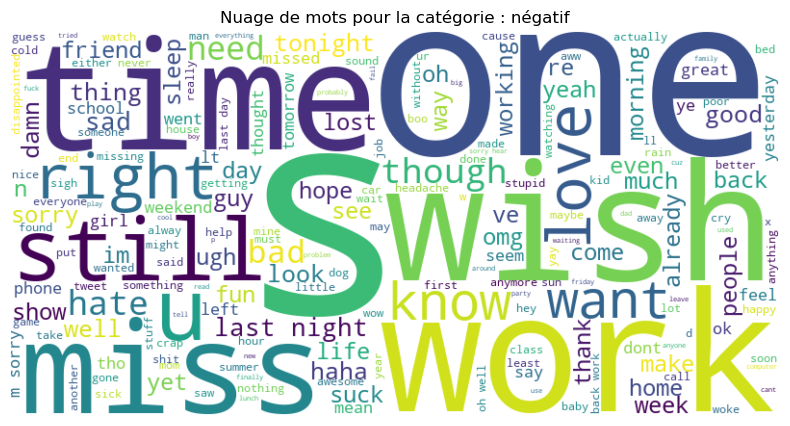

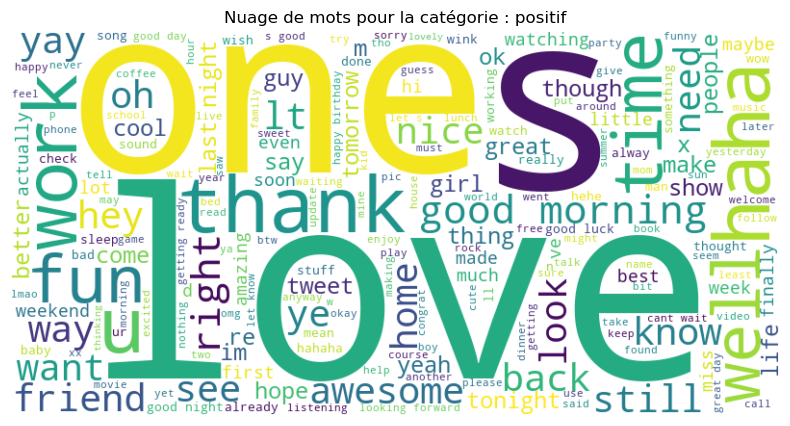

In [37]:
# Appel de la fonction pour générer un nuage de mots par catégorie
Nuage_de_mots(df_tweet_preproc, "sentiment", "tweet")

On voit tout de suite que les nuages de mots sont bien plus pertinents et qu'il va très certainement être plus facile de classifier les tweets à présent.

In [39]:
# Enregistrement du df en CSV
df_tweet_preproc.to_csv("tweet_preproc.csv", encoding="ISO-8859-1", index=False)

In [40]:
df_tweet_preproc["tweet"][208]

''

In [41]:
df_tweet_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596630 entries, 0 to 1596629
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   sentiment        1596630 non-null  object
 1   id               1596630 non-null  int64 
 2   date             1596630 non-null  object
 3   auteur           1596630 non-null  object
 4   tweet            1596630 non-null  object
 5   long_tweet       1596630 non-null  int64 
 6   label sentiment  1596630 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 85.3+ MB
